<a href="https://colab.research.google.com/github/Jinyu-Luo/CHL5230-Datathon4/blob/main/16_CHL5230_Datathon4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install statsmodels
!pip install category_encoders
!pip install klib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [2]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

import io
import seaborn as sns

from statsmodels.imputation import mice
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import klib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# upload the data
from google.colab import files
uploaded = files.upload()

Saving datathon4.csv to datathon4.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['datathon4.csv']))
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
# Removes duplicate and empty row/col
df = klib.data_cleaning(df)
print(df.info())

Shape of cleaned data: (91712, 179) - Remaining NAs: 5237705


Dropped rows: 1
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 7
     of which 1 single valued.     Columns: ['readmission_status']
Dropped missing values: 505787
Reduced memory by at least: 70.76 MB (-54.37%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Columns: 179 entries, encounter_id to apache_2_bodysystem
dtypes: category(8), float32(164), int16(2), int32(2), int8(3)
memory usage: 59.4 MB
None


In [6]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91712.000000,91712.000000,91712.000000,91712.000000,87485.000000,88283.000000,91712.000000,90378.000000,91712.000000,91712.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65605.949625,65537.475227,105.669574,0.086303,62.309517,29.185871,0.183738,169.641556,508.362003,0.835770,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.274197,37811.315008,62.854678,0.280812,16.775118,8.275176,0.387273,10.795433,228.987188,2.487770,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.199997,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32851.750000,32829.750000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65664.500000,65413.500000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100006,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.250000,98298.250000,161.000000,0.000000,75.000000,32.930260,0.000000,177.800003,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814987,1.000000,195.589996,927.000000,159.090973,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Variable of Interest**

In [7]:
df['hospital_death'].mean()

0.08630277390090718

Only 8% death events.

In [8]:
print(df['apache_3j_bodysystem'].unique().tolist())

['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma', 'Neurological', 'Gastrointestinal', 'Genitourinary', nan, 'Hematological', 'Musculoskeletal/Skin', 'Gynecological']


In [9]:
print(df['apache_2_bodysystem'].unique().tolist())

['Cardiovascular', 'Respiratory', 'Metabolic', 'Trauma', 'Neurologic', 'Gastrointestinal', 'Renal/Genitourinary', nan, 'Undefined diagnoses', 'Haematologic', 'Undefined Diagnoses']


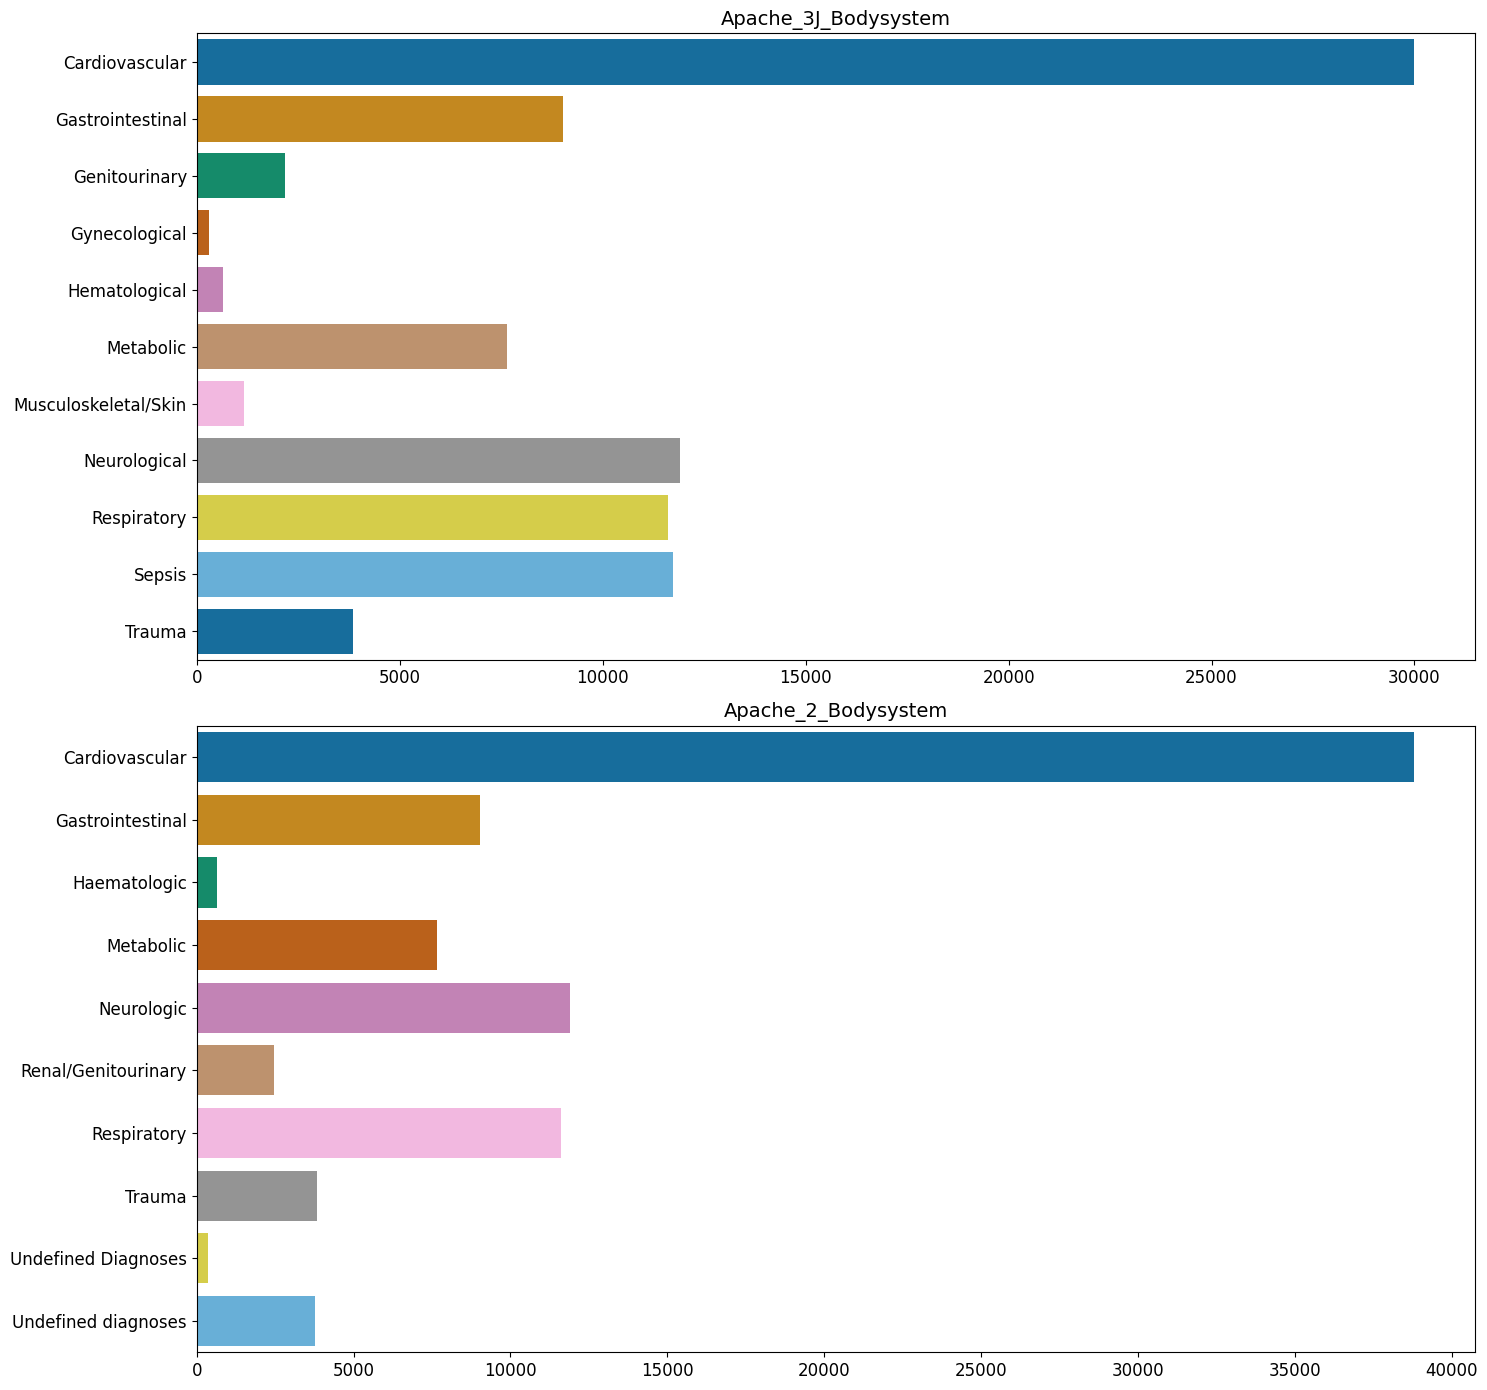

In [10]:
bodysystem = ['apache_3j_bodysystem', 'apache_2_bodysystem']
plt.figure(figsize = (15, 14))

for i, variable in enumerate(bodysystem, 1):
  plt.subplot(2, 1, i)
  sns.countplot(data=df, y=variable, palette="colorblind")
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(variable.title(), fontsize=14)
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()  # Show the plot

The column `apache_3j_bodysystem` is the primary reason for ICU admission into different body systems according to the APACHE III-J methodology. Each category represents the primary body system affected or the primary system that the illness is associated with.

We see that the majority patients who admitted to ICU had the illness mainly appear in cardiovascular system.

# Research Objective
Predict the mortality of patients admitted to the ICU with primary diagnoses related to the cardiovascular system, with a particular focus on those exhibiting renel impairment.  

[Reference]

*Acute deteriorations in renal function, previously referred to as worsening renal function but now as acute kidney injury (AKI), and defined as a rise in serum creatinine by more than 26.5 μmol/L (0.3 mg/dL) is observed in 20–40% of patients hospitalised with acute decompensated heart failure.*

The Acute Physiology and Chronic Health Evaluation (APACHE) II and APACHE III are scoring systems that being used to predict outcome and identify predictive factors for survival for patients in ICU unit beased on physiologic assessments during the first 24 hrs in ICU.

Since APACHE III is a more recent and detailed version with higher discriminative power, we will filter data according to APACHE III, i.e., the column `apache_3j_bodysystem`.

In [11]:
# Filter out the target population
card_df = df[df['apache_3j_bodysystem'] == 'Cardiovascular']

In [12]:
# Drop columns indicating APACHE score
card_df = card_df.drop(['apache_2_bodysystem', 'apache_3j_bodysystem'],
              axis = 1)

In [13]:
card_df.shape

(29999, 177)

### Check Uniqueness

Ensure that each identifier is unique and remove duplicates if exist.

In [14]:
# Checking for uniqueness in 'encounter_id', 'hospital_id', and 'patient_id'
unique_encounter_id = card_df['encounter_id'].is_unique
unique_patient_id = card_df['patient_id'].is_unique

print(f"Is 'encounter_id' unique for each record? {unique_encounter_id}")
print(f"Is 'patient_id' unique for each record? {unique_patient_id}")


Is 'encounter_id' unique for each record? True
Is 'patient_id' unique for each record? True


The results suggest that each encounter in the ICU is distincly recorded and each patient is uniquely identified in the dataset.

# Conceptual Predictor Variables

The APACHE III scoring system appears to have a higher discriminative power compared to the APACHE II scoring system. On multiple occasions, the APACHE II system under-predicted the actual in-hospital mortality rate.Therefore we should conceptualize our model with variables that were used to predict the highest possible APACHE III score.

Variables that would be interesting to include is ***wbc_apache - The white blood cell count measured during the first 24 hours which results in the highest APACHE III score*** as this has been an indicator for in-hospital mortality and has been used as a predictor in many clinical studies.

Additionally, all the ***APACHE comorbidity variables***, as shown in the bottom of the data dictionary, may be useful to include as predictors in our model as there have been individual indices used in clinical research specifically to predict the risk of death in patients with specific comorbid conditions.

# Data Preprocessing

[Handling missing values, normalizing/standardizing numerical variables, encoding categorical variables, etc.]

## Data Cleaning

### Features with over 60% missig values

In [15]:
# Calculate the percentage of missing
missing_perc = card_df.isnull().mean()*100

# Print columns with missing percentage >= 60% in descending order
print(missing_perc[missing_perc >= 60].sort_values(ascending=False))

d1_lactate_max            83.259442
d1_lactate_min            83.259442
h1_pao2fio2ratio_max      80.892696
h1_pao2fio2ratio_min      80.892696
h1_hco3_max               78.212607
h1_hco3_min               78.212607
h1_calcium_min            77.805927
h1_calcium_max            77.805927
h1_bun_min                76.899230
h1_bun_max                76.899230
h1_creatinine_min         76.672556
h1_creatinine_max         76.672556
h1_arterial_ph_min        75.942531
h1_arterial_ph_max        75.942531
h1_arterial_po2_min       75.252508
h1_arterial_po2_max       75.252508
h1_arterial_pco2_min      75.232508
h1_arterial_pco2_max      75.232508
h1_wbc_max                74.639155
h1_wbc_min                74.639155
ph_apache                 73.992466
pao2_apache               73.992466
paco2_for_ph_apache       73.992466
paco2_apache              73.992466
fio2_apache               73.992466
h1_platelets_max          73.675789
h1_platelets_min          73.675789
h1_sodium_min             72

Count the number of features that is greater than 90%, 80%, 70%, and 60%.

In [16]:
def countMissingCols(data):
  dicts = {}
  count90 = 0
  count80 = 0
  count70 = 0
  count60 = 0

  for column, perc in data.iteritems():
    if perc >= 90:
      count90+=1
    elif 80 <= perc < 90:
      count80+=1
    elif 70 <= perc < 80:
      count70+=1
    elif 60 <= perc < 70:
      count60+=1
  dicts['missing values > 90%: '] = count90
  dicts['80% <= missing values < 90%: '] = count80
  dicts['70% <= missing values < 80%: '] = count70
  dicts['60% <= missing values < 70%: '] = count60
  for key, val in dicts.items():
    print(key, val)
countMissingCols(missing_perc)

missing values > 90%:  0
80% <= missing values < 90%:  4
70% <= missing values < 80%:  31
60% <= missing values < 70%:  20


#### Arterial Blood Gas (ABG) Variables

- `fio2_apache`:  The fraction of inspired oxygen from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation
- `paco2_apache`:  The partial pressure of carbon dioxide from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation
- `paco2_for_ph_apache`:  The partial pressure of carbon dioxide from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for acid-base disturbance.  
- `pao2_apache`:  The partial pressure of oxygen from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation.
- `ph_apache`: The pH from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for acid-base disturbance.  

All the above mentioned columns have 74% missing values, suggesting that the majority of the observation did not receive any of the measurement during the first 24 hours of unit admission. Therefore, we will create a binary variable indicating whether or not arterial blood gas being measured during the first 24 hours of unit admission and remove the above mentioned columns.

In [17]:
# List of Arterial Blood Gas Variables
abg_variables = ['fio2_apache', 'paco2_apache', 'paco2_for_ph_apache',
                 'pao2_apache', 'ph_apache']

# Check if rows with a missing value in one ABG variable also have missing values in others
missing_in_all_abg = card_df[abg_variables].isnull().all(axis=1).sum()
missing_in_any_abg = card_df[abg_variables].isnull().any(axis=1).sum()

print(f"Number of rows missing in all ABG variables: {missing_in_all_abg}")
print(f"Number of rows missing in any ABG variable: {missing_in_any_abg}")

Number of rows missing in all ABG variables: 22197
Number of rows missing in any ABG variable: 22197


It seems like the missingness in the Arterial Blood Gas (ABG) variables is completely overlapping - that is, whenever one of these variables is missing, all of them are missing. Therefore, we can consider to create ONE indicator variable to represent whether any ABG measurements were taken.

In [18]:
# Create a single binary indicator variable
card_df['abg_measured'] = card_df[abg_variables].notnull().all(axis=1).astype(int)

# Check unique values in 'abg_measured'
print("Unique values in 'abg_measured':", card_df['abg_measured'].unique())

Unique values in 'abg_measured': [1 0]


#### Remove Features with over 60% missings

In [19]:
# Find the indices of columns with over 60% missing values
columns_to_drop = missing_perc[missing_perc>=60].index

# Remove these columns
data = card_df.drop(columns = columns_to_drop)

# Drop columns representing labels
columns_to_drop = ['hospital_admit_source','icu_admit_source','icu_id',
                   'encounter_id','patient_id','hospital_id']
data.drop(columns_to_drop, axis = 1, inplace=True)

data.shape

(29999, 117)

58 columns with over 60% missing values and 6 columns representing identifiers were dropped. The dataset left with 124 columns.

Since our goal is to build a predictive model, we need to exclude `apache_4a_hospital_death_prob` and `apache_4a_icu_death_prob` from our dataframe because they are estimates of the risk of death based on APACHE IV model.

In [20]:
# Remove predicted probabilities based on APACHE IV
data.drop(['apache_2_diagnosis','apache_4a_hospital_death_prob',
           'apache_4a_icu_death_prob'], axis = 1, inplace=True)

In [21]:
# uncomment the line below to check columns in current dataframe
data.columns.tolist()

['hospital_death',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'weight',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min

In [22]:
data.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_stay_type,icu_type,pre_icu_los_days,...,h1_inr_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,abg_measured
3,0,81.0,22.639999,1,Caucasian,F,165.100006,admit,CTICU,0.000694,...,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,1,45.0,NaN,0,Caucasian,M,170.199997,admit,CCU-CTICU,0.009028,...,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0,50.0,25.709999,0,NaN,M,175.300003,admit,CCU-CTICU,0.060417,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16,0,30.0,23.383179,0,Caucasian,M,193.000000,admit,Med-Surg ICU,0.240972,...,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
19,0,39.0,37.010277,1,NaN,M,177.800003,admit,CTICU,5.163889,...,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Selection of the Features by Clinical Importance

In the context of ICU data, common outcomes include:

*   **Mortality**: Whether the patient survives the ICU stay or the hospital stay. This is often the primary outcome of interest.
*   **Length of stay**: This is usually the secondary outcome, but it can be very informative about resources utilization and patient recovery.
*   **Readmission**: Whether the patient was readmitted to the ICU after discharge, which can be a sign of premature discharge or complications.

Therefore, our **outcome variable** is `hospital_death` which indicates whether the patient died during this hospitalization.  

**Demographic Features**

- **BMI**: Since BMI is calculated based on height and weight, we will remove height and weight after the calculation of BMI for missingness.  
  - We can encode BMI into binary variable to indicate obesity or not.  
- **age**: Age is a significant predictor of mortality in ICU patiients.  
- **gender**: Gender may influence the ooutcome.  
- **ethnicity**: Ethnic background can be relevant for risk stratification.

**Clinical Interventioons and ICU Information**

- **apache_post_operative**: Indicates if the ICU admission was post-surgical.
- **arf_apache**: Acute renal failure as identified by the APACHE system.

**Cardiovascular-Related Variables**:
- `heart_rate_apach`: Heart rate abnormalities can indicate cardiac stress or dysfunction.
map_apache: Mean arterial pressure is a critical parameter for assessing cardiovascular function.  
- `apache_post_operative`: Indicates if the ICU admission was post-surgical, which can be relevant for cardiovascular patients.

**Renal-Related Variables**:  
- `bun_apache`: Blood Urea Nitrogen levels.
- `creatinine_apache`: Serum creatinine levels.  
- `urineoutput_apache`: Total urine output, which can indicate kidney function.

**Laboratory Results**:  
* `heart_rate_apache`, `map_apache`, `resprate_apache`: Vital signs that are critical in assessing patient status.
* `hematocrit_apache`, `wbc_apache`: Blood cell counts can indicate various acute and chronic conditions.
* `sodium_apache`: Electrolyte balance is crucial, especially in renal and cardiovascular diseases.
* `ventilated_apache`: Mechanical ventilation status is a marker of severity.

**Comorbidity Indicators**:  
- `diabetes_mellitus`, `hepatic_failure`, `immunosuppression`, `leukemia`, `lymphoma`, `solid_tumor_with_metastasis`: Comorbid conditions can significantly affect mortality risk.

**Demographics**:
`age (in bins), gender, ethnicity, bmi`: Basic demographic information can be relevant for risk adjustment.  

**Treatment Variables**:  
- `arf_apache`: Acute renal failure as identified by the APACHE system.




### Calculate BMI

In [23]:
# Function to calculate BMI
def calculate_bmi(weight, height):
  if height > 0:
    height_in_meters = height/100 # convert height to meters
    bmi = weight / (height_in_meters ** 2)
    return bmi
  else:
    return None

# Impute BMI where height and weight are available
data.loc[card_df['bmi'].isnull(), 'bmi'] = card_df.apply(
    lambda row: calculate_bmi(row['weight'], row['height'])
    if pd.notnull(row['weight']) and pd.notnull(row['height'])
    else None,
    axis=1
)

# Check missings in BMI
data['bmi'].isnull().sum()

1166

There are still 1166 missing values in BMI after the imputation of calculated value based on height and weight, we will impute these missing later with the pipeline.

In [24]:
data.drop(['height', 'weight'], axis = 1, inplace = True)

## Check Missing and Imputation

In [25]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 hospital_death                    0
age                            1047
bmi                            1166
elective_surgery                  0
ethnicity                       551
                               ... 
immunosuppression                 0
leukemia                          0
lymphoma                          0
solid_tumor_with_metastasis       0
abg_measured                      0
Length: 112, dtype: int64


For columns representing demographic information, several of them exhibit missing values:

- `age` has 1,047 missing entires. Consider the significance of age in health-related outcomes, we would impute missing age using median value.  
- `bmi` contains 1,166 missing records.
- `ethnicity` has 551 missing values. Considering that the size of missing is relatively small compared to the size of the dataset, we will remove these observations directly.
- `gender` has the least number of missing values, with only 9 absent entries, which is relatively minor given the size of the dataset. Therefore, we will consider to remove these observations directly.

In [26]:
data.dropna(subset=['gender'], inplace = True)

In [27]:
data['ethnicity'].unique()

['Caucasian', NaN, 'African American', 'Hispanic', 'Asian', 'Native American', 'Other/Unknown']
Categories (6, object): ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
                         'Other/Unknown']

In [28]:
data['gender'].unique()

['F', 'M']
Categories (2, object): ['F', 'M']

To tidy up our data

1. Replace "Other/Unknown" in the `ethnicity` column with "Others" values to indicate missing data.  
2. Fill missing values in ethnicity by "Others".

In [29]:
# Ethnicity
data["ethnicity"].replace({"Other/Unknown": "Others"}, inplace = True)
data["ethnicity"].fillna("Others", inplace = True)

### Distribution of Classes

In [30]:
import plotly.express as px

counts = data['hospital_death'].value_counts()

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in Hospital Death',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Hospital Death'
    ),
    title=dict(
        text='Distribution of Classes in Hospital Death',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

An 92-8 split suggests that there is severe clasas imbalance in the dataset, with the death population representing approximately 8% of the data and the other 92%.

### `bun_apache` and `creaatinine_apache` imputation

In [31]:
# Create an IterativeImputer object
mice_imputer = IterativeImputer()

# Impute bun_apache and creatinine_apache using multiple imputation
columns_to_impute = ['bun_apache', 'creatinine_apache']

# Perform the imputation
data[columns_to_impute] = mice_imputer.fit_transform(data[columns_to_impute])
data[columns_to_impute].isnull().sum()

bun_apache           0
creatinine_apache    0
dtype: int64

### Age

In [32]:
print('Oldest individual in the dataset was of:', data['age'].max(), 'Years')
print('Youngest individual in the dataset was of:', data['age'].min(), 'Years')
print('Average age in the dataset:', data['age'].mean(), 'Years')

Oldest individual in the dataset was of: 89.0 Years
Youngest individual in the dataset was of: 17.0 Years
Average age in the dataset: 65.75272 Years


In [33]:
from statistics import mode

# Create a subset
df_age = data[['age']]

# Assigning differently imputed values to different columns
df_age['Age_Mean'] = df_age['age'].fillna(df_age['age'].mean())
df_age['Age_Median'] = df_age['age'].fillna(df_age['age'].median())
df_age['Age_Mode'] = df_age['age'].fillna(mode(df_age['age']))

# Obtain summary statistics
df_age.describe().T[['mean', 'std', 'min', '50%', 'max']]

,mean,std,min,50%,max
age,65.752724,13.868932,17.0,67.0,89.0
Age_Mean,65.752716,13.625621,17.0,67.0,89.0
Age_Median,65.796097,13.627537,17.0,67.0,89.0
Age_Mode,65.796097,13.627537,17.0,67.0,89.0


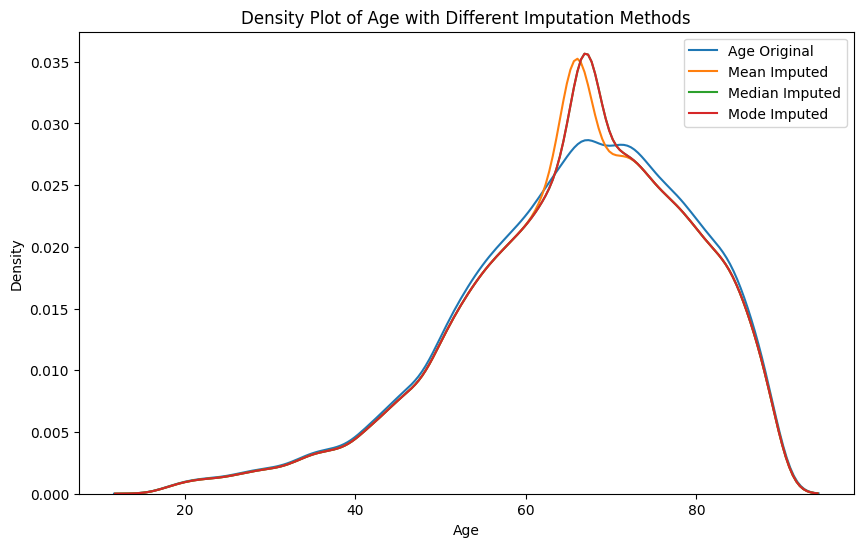

In [34]:
# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot density plots for each age column
sns.kdeplot(df_age['age'], label='Age Original')
sns.kdeplot(df_age['Age_Mean'], label='Mean Imputed')
sns.kdeplot(df_age['Age_Median'], label='Median Imputed')
sns.kdeplot(df_age['Age_Mode'], label='Mode Imputed')

# Add titles and labels
plt.title('Density Plot of Age with Different Imputation Methods')
plt.xlabel('Age')
plt.ylabel('Density')

# Show legend
plt.legend()

# Display the plot
plt.show()

Try to impute Age by KNN imputer

In [35]:
from sklearn.impute import KNNImputer
# Select only columns that is helpful in KNN imputation for age
age_cols = ["age", "bmi", "apache_3j_diagnosis", "arf_apache",
            "bun_apache", "creatinine_apache"]
df_age_cols = data[age_cols]

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the dataset
df_imputed_age = imputer.fit_transform(df_age_cols)

# Convert the imputed data back to a DataFrame
df_imputed_age = pd.DataFrame(df_imputed_age, columns=df_age_cols.columns)

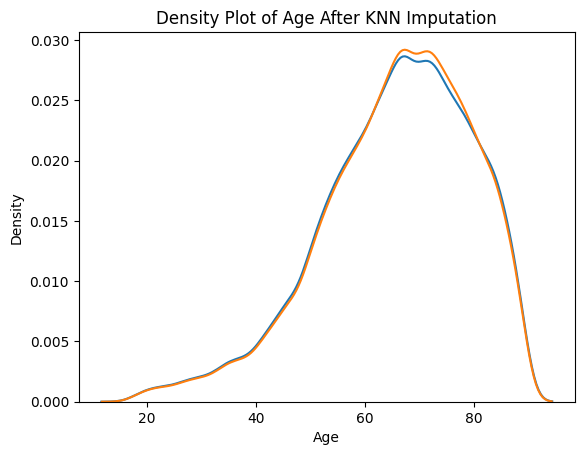

In [36]:
# Plot density plot for the imputed 'Age' column
sns.kdeplot(df_age['age'], label='Age Original')
sns.kdeplot(df_imputed_age['age'], label='Age (KNN Imputed)')

# Add titles and labels
plt.title('Density Plot of Age After KNN Imputation')
plt.xlabel('Age')
plt.ylabel('Density')

# Display the plot
plt.show()

In [37]:
df_imputed_age.isnull().sum()

age                    0
bmi                    0
apache_3j_diagnosis    0
arf_apache             0
bun_apache             0
creatinine_apache      0
dtype: int64

In [38]:
# Reset the indices of both DataFrames
data.reset_index(drop=True, inplace=True)
df_imputed_age.reset_index(drop=True, inplace=True)

# Replace the 'age' column in 'data' with the 'age' column from 'df_imputed_age'
data['age'] = df_imputed_age['age']
data['age'].isnull().sum()

0

In [39]:
# Filter out observations where age is greater than or equal to 40
data = data[data['age'] >= 40]

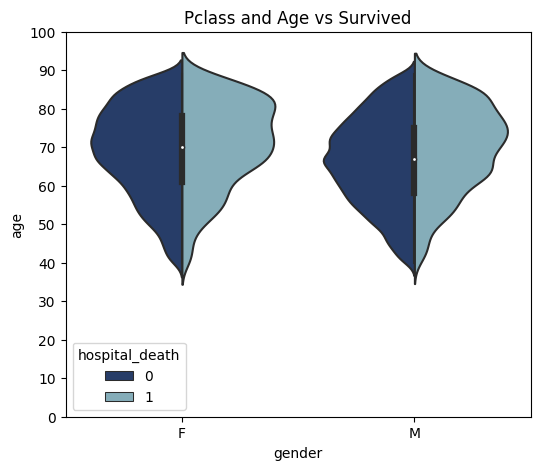

In [40]:
plt.figure(figsize=(6, 5))
sns.violinplot(x="gender", y="age", hue="hospital_death",
               data=data, split=True, palette=['#1c3a73', '#7cb1c2'])
plt.title('Pclass and Age vs Survived')
plt.yticks(range(0, 110, 10))
plt.show()

## Feature Selection by Variance Threshold

In [41]:
from sklearn.feature_selection import VarianceThreshold

numerical_cols = data.select_dtypes(include=['int8', 'float32', 'float64']).columns
df_numerical = data[numerical_cols]
df_numerical.drop(['hospital_death','age','bmi'], axis = 1, inplace = True)

# Removing both constant and quasi-constant
var_thr = VarianceThreshold(threshold = 0.25)
var_thr.fit(df_numerical)

var_thr.get_support()

array([False,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False])

OUTPUT above:
*   True: High Variance
*   False: Low Variance


In [42]:
concol = [column for column in df_numerical.columns
          if column not in df_numerical.columns[var_thr.get_support()]]

# Print column names with low variance
# We will drop them from the data set
for features in concol:
    print(features)

elective_surgery
apache_post_operative
arf_apache
gcs_unable_apache
intubated_apache
ventilated_apache
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis


In [43]:
selected_features = ['hospital_death','age','bmi', 'gender', 'ethnicity',
                     'icu_stay_type','icu_type']+ df_numerical.columns[var_thr.get_support()].tolist()
data_clean = data[selected_features]

In [44]:
data_clean.shape

(28636, 97)

In [45]:
len(selected_features)

97

In [46]:
data_clean['gender'].replace({'F' : 1, 'M' : 0}, inplace=True)

## Multicollinearity Check

## Data Transformation

In [47]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# Define a function to preprocess and transform input data
def fit_transform(input_df):
    # Initialize transformers and imputers
    ethnicity_transformer = ce.TargetEncoder()
    stayType_transformer = ce.TargetEncoder()
    icuType_transformer = ce.TargetEncoder()

    imputer = IterativeImputer(max_iter=10, random_state=0)
    st_x = StandardScaler()

    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.fit_transform(
            df['ethnicity'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Encode 'icu_stay_type' column if it exists
    if 'icu_stay_type' in df.columns:
        df['icu_stay_type'] = stayType_transformer.fit_transform(
            df['icu_stay_type'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Encode 'icu_type' column if it exists
    if 'icu_type' in df.columns:
        df['icu_type'] = icuType_transformer.fit_transform(
            df['icu_type'].to_numpy().reshape(-1, 1), df['hospital_death'].to_numpy()
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.fit_transform(df.drop('hospital_death', axis=1).to_numpy())
    X = st_x.fit_transform(X)

    # Extract the target variable 'Class/ASD'
    Y = df['hospital_death'].to_numpy()

    # Return the preprocessed feature matrix, target variable, and transformers/imputers
    return X, Y, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x

# Define a function to transform new data using pre-trained transformers and imputers
def transform(input_df, ethnicity_transformer, stayType_transformer,
              icuType_transformer, imputer, st_x):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.transform(
            df['ethnicity'].to_numpy().reshape(-1, 1)
        )

    # Encode 'icu_stay_type' column if it exists
    if 'icu_stay_type' in df.columns:
        df['icu_stay_type'] = stayType_transformer.transform(
            df['icu_stay_type'].to_numpy().reshape(-1, 1)
        )

     # Encode 'icu_type' column if it exists
    if 'icu_type' in df.columns:
        df['icu_type'] = icuType_transformer.transform(
            df['icu_type'].to_numpy().reshape(-1, 1)
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.transform(df.drop('hospital_death', axis=1).to_numpy())
    X = st_x.transform(X)

    # Return the transformed feature matrix
    return X

In [48]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)


Feature Selection

[Determining which variables (demographics, vitals, lab results, APACHE scores, comorbidities) to include in the model.]

Vasoactive management considerations and rationale:
1. blood pressure
2. beats per minute
3. cardiogenic shock
4. heart rate
5. diastolic pressure
6. pulmonary artery catheter
7. pulmonary vascular resistance
8. systemic vascular resistance


In [49]:
# create list of numerical, categorical, multinomial features
target_column = 'hospital_death'
# numerical_columns = ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
#                     'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
#                     'd1_mbp_noninvasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max',
#                     'd1_sysbp_noninvasive_min']

# Model Building

## Logistic Regression

In [50]:
data_clean.describe()

,hospital_death,age,bmi,pre_icu_los_days,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,...,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min
count,28636.000000,28636.000000,27530.000000,28636.000000,28636.000000,28636.000000,28636.000000,28279.000000,28279.000000,28279.000000,...,25707.000000,25707.000000,25024.000000,25024.000000,24270.000000,24270.000000,13537.000000,13537.000000,12060.00000,12060.000000
mean,0.079411,67.531822,29.731020,0.925766,447.975830,24.540588,1.463831,3.557021,5.486898,4.171329,...,4.333427,3.956132,139.218994,137.771164,12.294932,10.752614,160.797867,150.585281,1.56534,1.446536
std,0.270383,11.666387,7.551252,2.318365,509.107086,15.328356,1.242141,0.935992,1.387899,1.520528,...,0.637992,0.540416,4.330657,4.204604,6.104635,4.910347,71.650452,69.295380,0.87658,0.685961
min,0.000000,40.000000,14.844926,-0.250000,101.010002,4.000000,0.300000,1.000000,1.000000,1.000000,...,2.800000,2.400000,123.000000,117.000000,1.200000,0.900000,59.000000,42.000000,0.90000,0.900000
25%,0.000000,59.000000,24.742218,0.043056,106.010002,15.000000,0.840000,4.000000,6.000000,4.000000,...,3.900000,3.600000,137.000000,136.000000,8.162500,7.500000,116.000000,109.000000,1.10000,1.100000
50%,0.000000,68.000000,28.515625,0.164583,108.010002,23.000000,1.230000,4.000000,6.000000,5.000000,...,4.200000,3.900000,139.000000,138.000000,11.000000,9.860000,142.000000,133.000000,1.30000,1.220000
75%,0.000000,77.000000,33.299355,0.531250,1205.010010,25.000000,1.468432,4.000000,6.000000,5.000000,...,4.600000,4.300000,142.000000,140.000000,14.860000,12.870000,182.000000,169.000000,1.60000,1.500000
max,1.000000,89.000000,67.814987,63.044445,1212.030029,127.000000,11.180000,4.000000,6.000000,5.000000,...,7.000000,5.800000,158.000000,153.000000,46.080002,40.897999,695.044983,670.000000,7.75600,6.127000


======== Training Set ==========
AUC :  0.825154668432504
Accuracy :  0.9383387378398603
Confusion Matrix:
[[18230   990]
 [  246   579]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     19220
           1       0.37      0.70      0.48       825

    accuracy                           0.94     20045
   macro avg       0.68      0.83      0.73     20045
weighted avg       0.96      0.94      0.95     20045

======== Test Set ==========
AUC :  0.8362433220009713
Accuracy :  0.9366779187521825
Confusion Matrix:
[[7789  447]
 [  97  258]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8236
           1       0.37      0.73      0.49       355

    accuracy                           0.94      8591
   macro avg       0.68      0.84      0.73      8591
weighted avg       0.96      0.94      0.95      8591



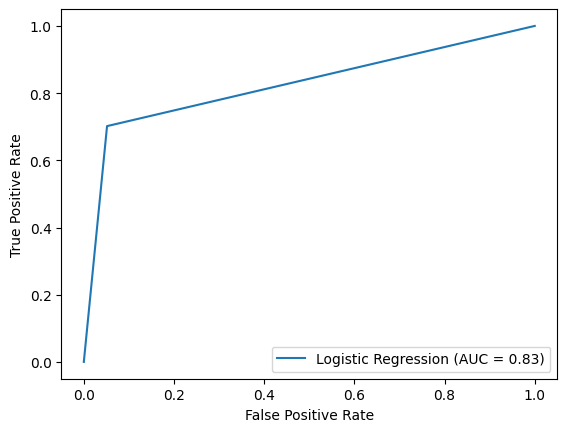

In [51]:
from sklearn.linear_model import LogisticRegression

# Splitting the dataset into training and test sets
train = data_clean.sample(frac=0.7, random_state=10)  # 70% for training
test = data_clean.drop(train.index)  # Remaining data for testing

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer,
                   icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='Logistic Regression')
display.plot()

## Logistic Regression with Weighted Classes

======== Training Set ==========
AUC :  0.6682606946468024
Accuracy :  0.8721376901970567
Confusion Matrix:
[[16246   333]
 [ 2230  1236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     16579
           1       0.79      0.36      0.49      3466

    accuracy                           0.87     20045
   macro avg       0.83      0.67      0.71     20045
weighted avg       0.86      0.87      0.85     20045

======== Test Set ==========
AUC :  0.6643909047088742
Accuracy :  0.8661389826562682
Confusion Matrix:
[[6907  171]
 [ 979  534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      7078
           1       0.76      0.35      0.48      1513

    accuracy                           0.87      8591
   macro avg       0.82      0.66      0.70      8591
weighted avg       0.86      0.87      0.85      8591



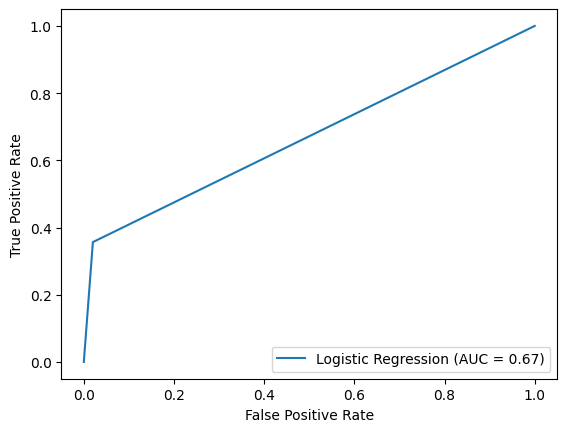

In [52]:
# Preprocess and transform the training set using the fit_transform function
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set using the transform function
X_test = transform(test, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x)

# Extract the target variable from the test set
Y_test = test['hospital_death'].to_numpy()

# Define a weight 'a' for class 0 and class 1 in the Logistic Regression model
a = 0.1

# Initialize and train a Logistic Regression model with class weights
model = LogisticRegression(class_weight={0: a, 1: 1-a})
model.fit(X_train, Y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

## Logistic Regression with Cross Validation and Weighted Class

## Naive Bayes

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

## Different set of conceptual varia

## Splitting the original dataset into training, validation, and test sets
# Taking 70% of the data for training
train_dataClean = data_clean.sample(frac = 0.7)

# Removing the training data from the original dataset to get the combined validation and test data
test_dataClean = data_clean.drop(train_dataClean.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_dataClean = test_dataClean.sample(frac = 0.5)
test_dataClean = test_dataClean.drop(valid_dataClean.index)

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report




## Neural Net


In [53]:
# Splitting the dataset into training and test sets
train = data_clean.sample(frac=0.7, random_state=10)  # 70% for training
test = data_clean.drop(train.index)  # Remaining data for testing

# Feature engineering and preprocessing on the training set
X_train, Y_train, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, ethnicity_transformer, stayType_transformer, icuType_transformer, imputer, st_x)
Y_test = test['hospital_death'].to_numpy()

In [54]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5
# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((96, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)
# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)
# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [55]:
# Define the forward pass of the neural network
def forward(input):
  # First hidden layer with tanh activation
  out = tanh(input @ W1 + B1)

  # Second hidden layer with tanh activation
  out = tanh(out @ W2 + B2)

  # Output layer with sigmoid activation (since it's a binary classificati
  out = sigmoid(out @ W3 + B3)
  return out

In [56]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

In [57]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .5

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Text(0, 0.5, 'loss')

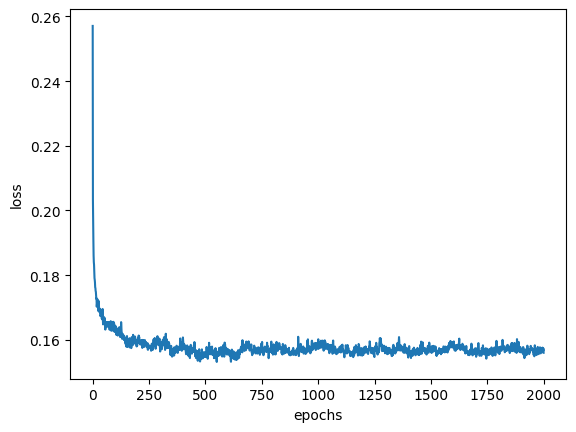

In [58]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

### Evaluate Neural Net Performance on Validation Data

In [59]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    pred_val = (probs >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the validation loss
    print(loss.item())

    # Generate and print the classification report for validation data
    report_val = classification_report(Y_numpy, pred_val, target_names=['Class 0', 'Class 1'])
    print("Validation Classification Report:\n", report_val)


    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs_train = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs_train.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Calculate predictions on the training data
    probs_train = forward(X)
    predictions_train = (probs_train >= 0.5).type(t.LongTensor).view(-1).numpy()  # Convert probabilities to binary predictions
    Y_train_numpy = Y.numpy()  # Convert tensor to numpy array for comparison

    # Print the training loss
    print(loss.item())

    # Generate and print the classification report for training data
    report_train = classification_report(Y_train_numpy, predictions_train, target_names=['Class 0', 'Class 1'])
    print("Training Classification Report:\n", report_train)

0.1943497210741043
Validation Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96      7886
     Class 1       0.65      0.36      0.46       705

    accuracy                           0.93      8591
   macro avg       0.80      0.67      0.71      8591
weighted avg       0.92      0.93      0.92      8591

0.15650618076324463
Training Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97     18476
     Class 1       0.77      0.42      0.55      1569

    accuracy                           0.95     20045
   macro avg       0.86      0.71      0.76     20045
weighted avg       0.94      0.95      0.94     20045



The output indicates that the model's loss on the validation set is slightly higher than the loss on the training dataset, suggesting that the probability of overfitting on the training data is very low.  

### Regularized Training of Neural Network

In [61]:
import torch.nn as nn
# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 96
number_of_hidden_units = 5
epochs = 100
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Lists to store predictions and actual labels
train_preds, train_labels = [], []
val_preds, val_labels = [], []


for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()
        train_preds.extend(prediction.tolist())
        train_labels.extend(Y_train_tensor.tolist())

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()
        val_preds.extend(prediction.tolist())
        val_labels.extend(Y_test_tensor.tolist())

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))


Epoch 0/100 ---> Train Accuracy: 0.9303067922592163, Validation Accuracy: 0.9277150630950928
Epoch 1/100 ---> Train Accuracy: 0.935195803642273, Validation Accuracy: 0.9330694675445557
Epoch 2/100 ---> Train Accuracy: 0.9321526288986206, Validation Accuracy: 0.93388432264328
Epoch 3/100 ---> Train Accuracy: 0.9349962472915649, Validation Accuracy: 0.9337679147720337
Epoch 4/100 ---> Train Accuracy: 0.9337490797042847, Validation Accuracy: 0.9320218563079834
Epoch 5/100 ---> Train Accuracy: 0.92866051197052, Validation Accuracy: 0.9286462664604187
Epoch 6/100 ---> Train Accuracy: 0.9314542412757874, Validation Accuracy: 0.928413450717926
Epoch 7/100 ---> Train Accuracy: 0.9322025179862976, Validation Accuracy: 0.9310906529426575
Epoch 8/100 ---> Train Accuracy: 0.9327014088630676, Validation Accuracy: 0.9333022832870483
Epoch 9/100 ---> Train Accuracy: 0.928610622882843, Validation Accuracy: 0.9288790822029114
Epoch 10/100 ---> Train Accuracy: 0.9337989687919617, Validation Accuracy: 0.

In [62]:
# After training, calculate and print classification report and AUC score
print("Training Classification Report:")
print(classification_report(train_labels, train_preds))
print("Training AUC Score:", roc_auc_score(train_labels, train_preds))

print("Validation Classification Report:")
print(classification_report(val_labels, val_preds))
print("Validation AUC Score:", roc_auc_score(val_labels, val_preds))

Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96   1847600
         1.0       0.63      0.33      0.44    156900

    accuracy                           0.93   2004500
   macro avg       0.79      0.66      0.70   2004500
weighted avg       0.92      0.93      0.92   2004500

Training AUC Score: 0.6584400883664073
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96    788600
         1.0       0.66      0.34      0.45     70500

    accuracy                           0.93    859100
   macro avg       0.80      0.66      0.71    859100
weighted avg       0.92      0.93      0.92    859100

Validation AUC Score: 0.6632705072100121


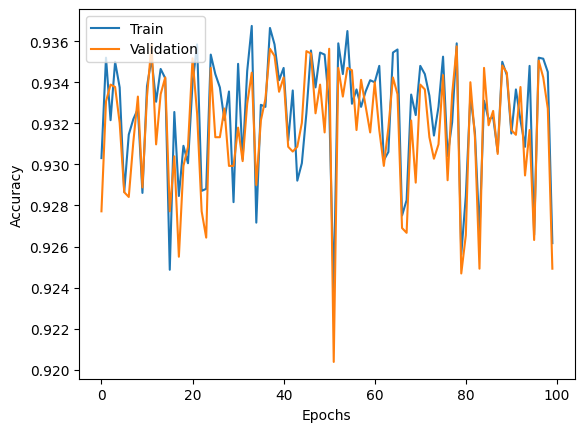

In [63]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Model Comparison